In this project I will be creating a model to predict the rates of violent crimes by municipality in New York State. The data I will use includes information for municipalities outside of New York City.

I will start by importing our pandas and numpy libraries. The first two datasets I am reading in are from [OpenDataNY](data.ny.gov). I have downloaded them to csv files for this project. The `EcRegion` dataset is a crosswalk of counties to regions of the State. This is a self defined list based on where I believe certain cultural and economic borders exist.

* `crime` includes the index crimes by police agency by year: [Index Crimes by County and Agency: Beginning 1990](https://data.ny.gov/Public-Safety/Index-Crimes-by-County-and-Agency-Beginning-1990/ca8h-8gjq)
* `leo` is the number of personnel by police agency (both civilian and sworn) by year: [Law Enforcement Personnel by Agency: Beginning 2007](https://data.ny.gov/Public-Safety/Law-Enforcement-Personnel-by-Agency-Beginning-2007/khn9-hhpq)
* `EcReg` assigns each agency to a region based on their location within New York

In [1]:
import pandas as pd
import numpy as np

crime = pd.read_csv(r"Index_Crimes_by_County_and_Agency__Beginning_1990.csv")
leo = pd.read_csv(r"Law_Enforcement_Personnel_by_Agency___Beginning_2007.csv")
EcReg = pd.read_csv(r"EcRegion.csv").assign(County = lambda x: x["County Name"].str.title().str.strip())\
.drop(['County Name'],axis=1)

merged = pd.merge(leo,crime,right_on=['Agency','Year','County'],left_on=['PD','Year','County'])\
.query(" `Violent Total` > 5 & `Months Reported` > 0")\
.drop(['Region','PD'],axis=1)\
.replace(to_replace=r'Vg', value='Village', regex=True)\
.merge(EcReg,how='left')

merged['Municipality Type'] = merged['Agency'].str.extract(r"(Village|City|Town|County)")
merged = merged.query("`Municipality Type` != 'County'").dropna()

I have excluded records of agencies and years that have less than 5 violent crimes or have a record with zero reporting months. Additionally, I have created a new field called "Municipality Type" that is derived from the police agency name. This will result in a column that indicates whether the municipality is a town, village, city, or county.

Furthermore, I have excluded counties from the dataset for a number of reasons. First, county sheriff deputies differ from other municipalities in that they have jurisdictional overlap with towns, cities, and villages. Second, the role of sheriff deputies varies widely; in smaller counties they are relied upon much more than counties with large urban centers. Third, the sample size in training data would most likely be too small considering there are only 50 counties in New York outside of New York City and may skew the model.

In [2]:
merged.shape

(2686, 25)

In [3]:
merged.columns

Index(['County', 'Year', 'Sworn Full Time', 'Sworn Part Time', 'Sworn Total',
       'Civilian Full Time', 'Civilian Part Time', 'Civilian Total',
       'Full Time Total', 'Part Time Total', 'Grand Total', 'Agency',
       'Months Reported', 'Index Total', 'Violent Total', 'Murder', 'Rape',
       'Robbery', 'Aggravated Assault', 'Property Total', 'Burglary',
       'Larceny', 'Motor Vehicle Theft', 'Economic Region',
       'Municipality Type'],
      dtype='object')

After checking the shape and columns present in the merged data I will move on to population metrics. Here I am reading in the census information for the 2010 and 2020 census. It contains enough overlapping data to merge, I just have to rename a few to align with the megred data.

I'll assign a size by municipality type such that cities are compared with cities and towns are compared with towns. Otherwise cities would always be in the largest category. I'm using `qcut` to slice the municipality sizes into equal data points.

Finally, I remove the municipality type from the municipality name.

In [4]:
pop = pd.read_csv("Census_2010_and_2020_Population__Region__Counties__Cities__Towns__Villages.csv").\
rename(columns={"Area Type":"Municipality Type","Area Name":"Municipality"})

pop['Municipality Size'] = pop.groupby(['Municipality Type'])['2010 Census Population'].transform(
                     lambda x: pd.qcut(x, 6, labels=False,duplicates="drop"))

pop = pop[['Municipality Type','Municipality','Municipality Size','Population Percent Change','2010 Census Population']]\
.assign(Municipality = lambda x: x.Municipality.replace(to_replace=r'village|city|town|County| and', 
                                                 value='', regex=True).str.strip())

pop.drop_duplicates(subset=['Municipality',"Municipality Type"])

pop.sample(10)

,Municipality Type,Municipality,Municipality Size,Population Percent Change,2010 Census Population
951,Town,Chautauqua,3.0,-0.1019,4464.0
1587,Village,Yorkville,3.0,-0.0119,2689.0
320,Town,La Grange,5.0,0.0156,15730.0
261,Town,Elma,5.0,0.0357,11317.0
207,Town,Cochecton,1.0,0.0554,1372.0
1265,Village,Head of the Harbor,2.0,0.0326,1472.0
667,Town,Enfield,3.0,-0.0427,3512.0
74,City,Dunkirk,1.0,0.0143,12563.0
155,Town,Canandaigua,5.0,0.1087,10020.0
765,Town,Portville,3.0,-0.0606,3730.0


I'll merge the base data with the population data now and remove the municipality name from the police agency to create a new `Municipality` column in the base data.

In [5]:
merged = merged.\
assign(Municipality = lambda x: x.Agency.replace(to_replace=r'Village|City|Town|County|PD|Sheriff| and', 
                                                 value='', regex=True).str.strip())\
.merge(pop,how="left",on=['Municipality','Municipality Type'])
merged['Municipality Size'] = np.where(merged['Municipality Size'].notnull() == True,merged['Municipality Size'],1)

merged

,County,Year,Sworn Full Time,Sworn Part Time,Sworn Total,Civilian Full Time,Civilian Part Time,Civilian Total,Full Time Total,Part Time Total,...,Property Total,Burglary,Larceny,Motor Vehicle Theft,Economic Region,Municipality Type,Municipality,Municipality Size,Population Percent Change,2010 Census Population
0,Albany,2007,334,0,334,123,71,194,457,71,...,4246.0,963.0,2997.0,286.0,Capital District,City,Albany,5.0,0.0140,97856.0
1,Albany,2008,332,0,332,124,9,133,456,9,...,4429.0,1034.0,3170.0,225.0,Capital District,City,Albany,5.0,0.0140,97856.0
2,Albany,2009,327,0,327,136,58,194,463,58,...,4250.0,877.0,3140.0,233.0,Capital District,City,Albany,5.0,0.0140,97856.0
3,Albany,2010,327,0,327,138,66,204,465,66,...,4638.0,923.0,3489.0,226.0,Capital District,City,Albany,5.0,0.0140,97856.0
4,Albany,2011,312,0,312,132,59,191,444,59,...,4605.0,890.0,3547.0,168.0,Capital District,City,Albany,5.0,0.0140,97856.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2699,Wyoming,2013,5,7,12,0,6,6,5,13,...,78.0,5.0,73.0,0.0,Finger Lakes,Village,Warsaw,4.0,0.0498,3473.0
2700,Wyoming,2015,5,7,12,0,1,1,5,8,...,78.0,11.0,67.0,0.0,Finger Lakes,Village,Warsaw,4.0,0.0498,3473.0
2701,Wyoming,2018,5,8,13,0,1,1,5,9,...,59.0,9.0,49.0,1.0,Finger Lakes,Village,Warsaw,4.0,0.0498,3473.0
2702,Wyoming,2020,5,8,13,0,1,1,5,9,...,31.0,5.0,25.0,1.0,Finger Lakes,Village,Warsaw,4.0,0.0498,3473.0


Next, I want to determine the crime/officer correlation. Of course, we expect this to be a strong correlation, but I will split it by muni type and examine the dispersion.

`Index Total` (x axis) is all the violent and property crime and `Sworn Total` (y axis) is all sworn officers, both full and part time.

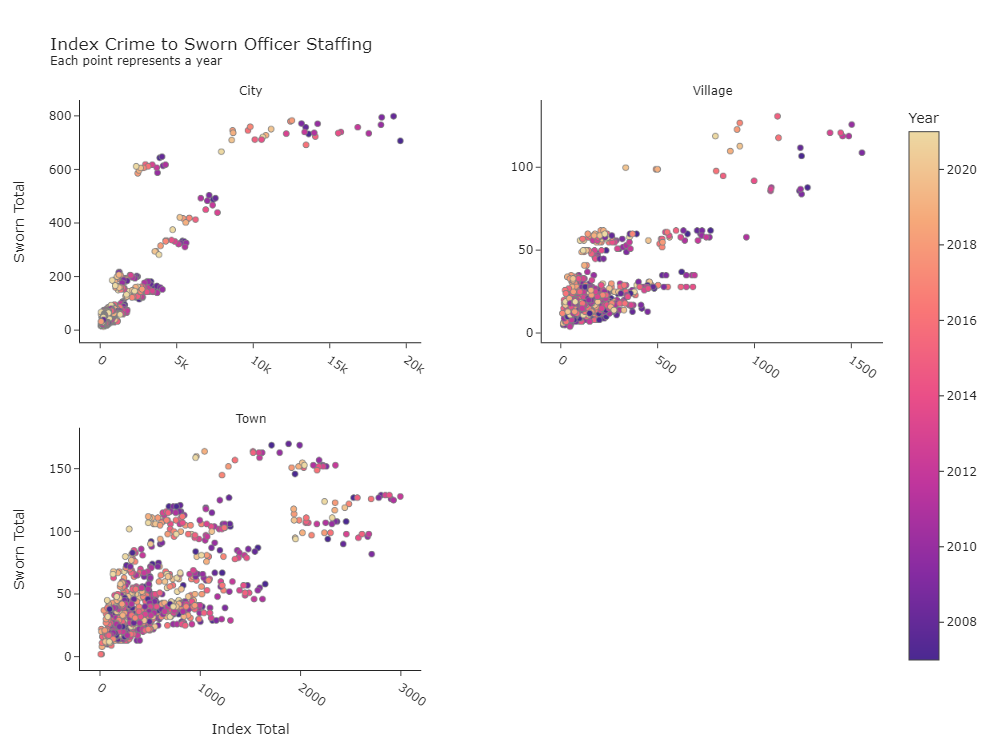

In [6]:
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

fig = px.scatter(merged,
                 x="Index Total",
                 y="Sworn Total",
                 title="Index Crime to Sworn Officer Staffing<br><sup>Each point represents a year",
                 facet_col = "Municipality Type",
                 facet_col_wrap=2,
                 facet_row_spacing = .15,
                 facet_col_spacing = .15,
                 color="Year",
                 color_continuous_scale=px.colors.sequential.Agsunset ,
                 template="simple_white").\
update_xaxes(matches=None, showticklabels=True, visible=True).\
update_yaxes(matches=None, showticklabels=True, visible=True).\
for_each_xaxis(lambda x: x.update(tickangle = 35)).\
for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].replace("_"," ").title())).\
update_traces(marker_line_width=0.75,marker_line_color="grey")

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

Cities have a very strong correlation between sworn officers and index crime. Towns and villages have a very wide spread of staffing to crime rate.

Next I will generate the same plot, but substituting the x and y axis for property crime and violent crime.

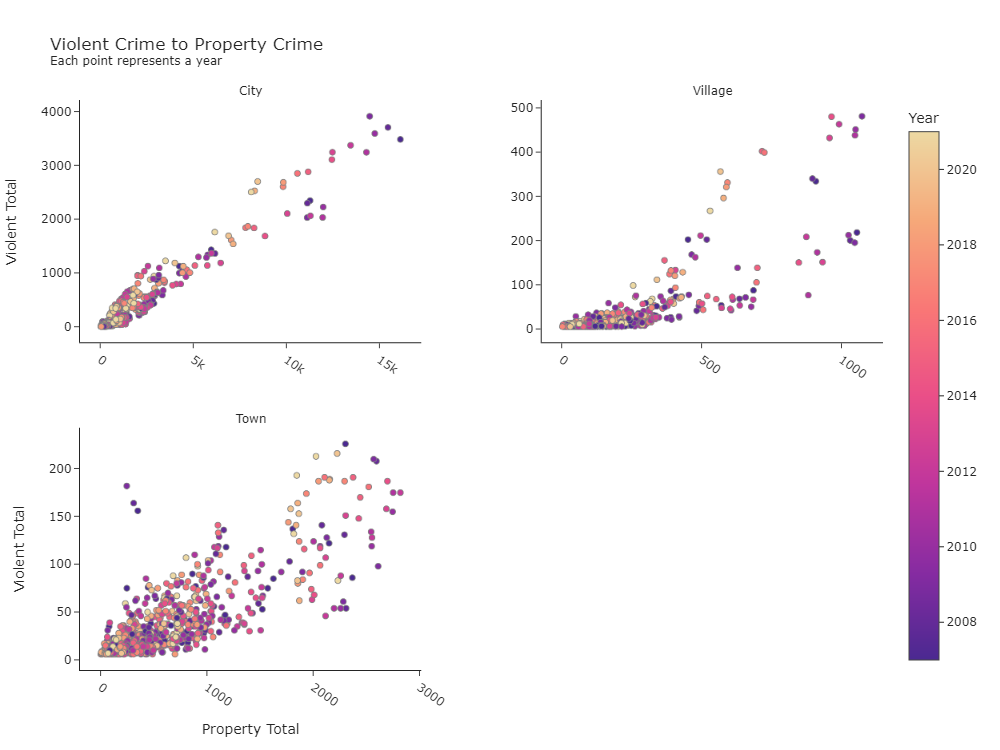

In [7]:
fig = px.scatter(merged,
                 x="Property Total",
                 y="Violent Total",
                 title="Violent Crime to Property Crime<br><sup>Each point represents a year",
                 facet_col = "Municipality Type",
                 facet_col_wrap=2,
                 facet_row_spacing = .15,
                 facet_col_spacing = .15,
                 color="Year",
                 color_continuous_scale=px.colors.sequential.Agsunset ,
                 template="simple_white").\
update_xaxes(matches=None, showticklabels=True, visible=True).\
update_yaxes(matches=None, showticklabels=True, visible=True).\
for_each_xaxis(lambda x: x.update(tickangle = 35)).\
for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].replace("_"," ").title())).\
update_traces(marker_line_width=0.75,marker_line_color="grey")

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

Here again we see a tight correlation for cities, while towns are much more dispersed. An interesting point for villages is that it seems that only after ~300 property crimes does violent crime seem to rise.

Moving on, I will also visualize violent and property crime over time, again split by municipality type.

C:\Users\arua\AppData\Local\Temp\ipykernel_16536\232118485.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



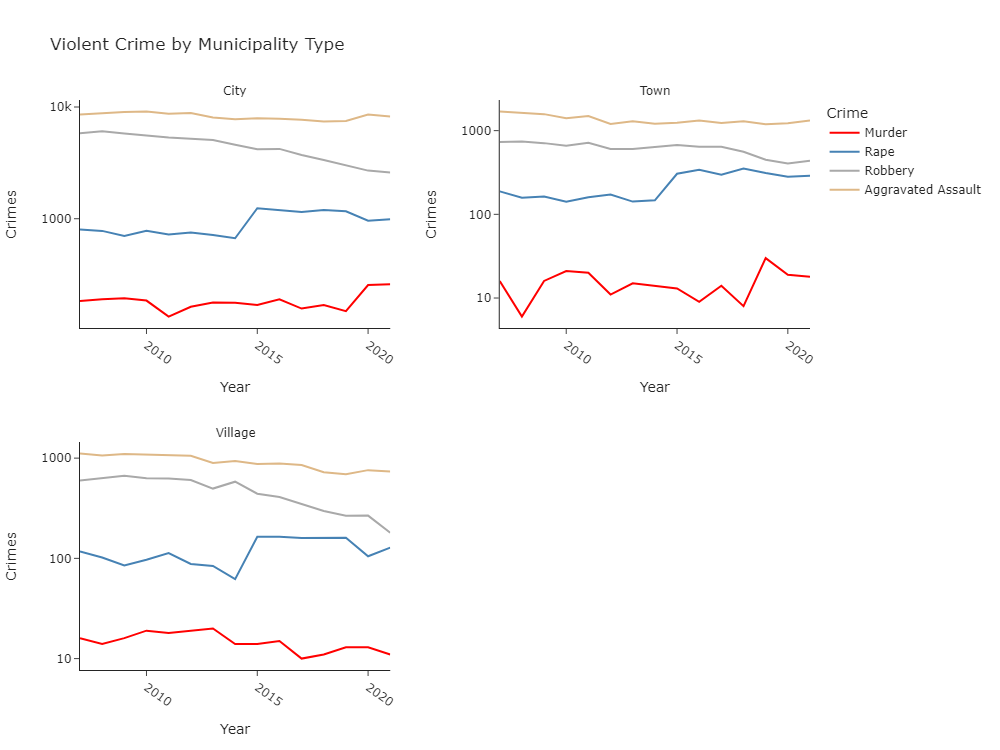

In [8]:
fig = px.line(merged.groupby(["Municipality Type","Year"]).sum().reset_index(),
                 x="Year",
                 y=["Murder","Rape","Robbery","Aggravated Assault"],
                 facet_col = "Municipality Type",
                 facet_col_wrap=2,
                 log_y=True,
                 facet_row_spacing = .20,
                 facet_col_spacing = .15,
                 color_discrete_map = {"Murder":'red',"Rape":"steelblue",
                                       "Robbery":"darkgrey","Aggravated Assault":"burlywood"},
                 title="Violent Crime by Municipality Type",
                 template="simple_white").\
update_xaxes(matches=None, showticklabels=True, visible=True,title="Year").\
update_yaxes(matches=None, showticklabels=True,dtick=1, visible=True,title="Crimes").\
for_each_xaxis(lambda x: x.update(tickangle = 35)).\
for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].replace("_"," ").title())).\
update_layout(legend_title="Crime")

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

C:\Users\arua\AppData\Local\Temp\ipykernel_16536\1160467237.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



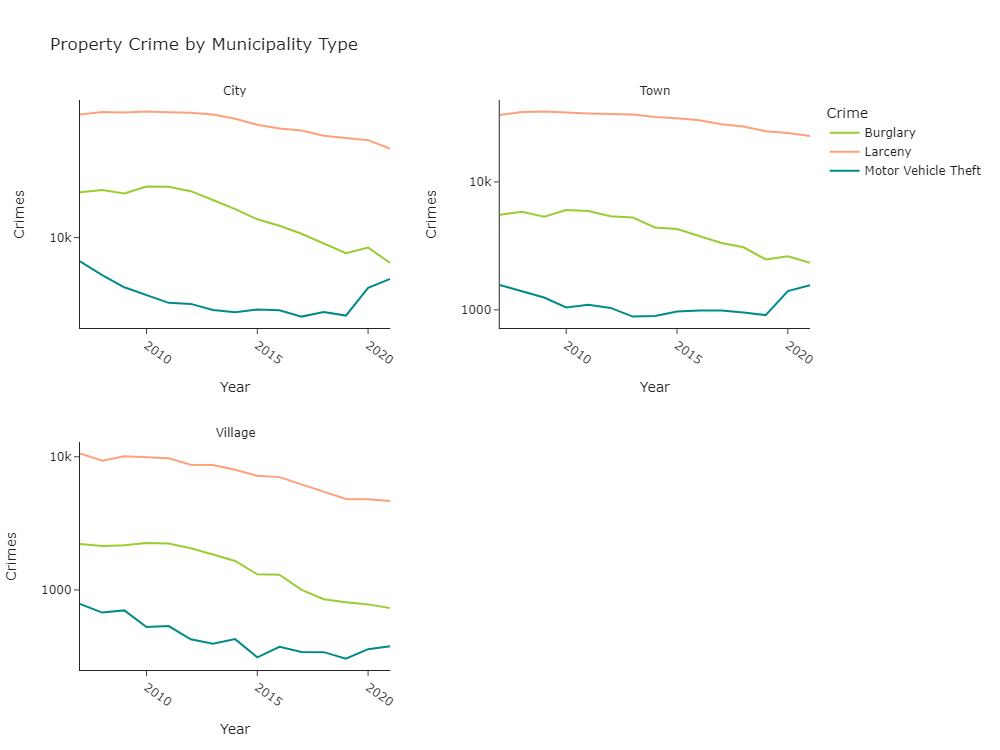

In [9]:
fig = px.line(merged.groupby(["Municipality Type","Year"]).sum().reset_index(),
                 x="Year",
                 y=['Burglary', 'Larceny','Motor Vehicle Theft'],
                 facet_col = "Municipality Type",
                 facet_col_wrap=2,
                 log_y=True,
                 facet_row_spacing = .20,
                 facet_col_spacing = .15,
                 title="Property Crime by Municipality Type",
                 color_discrete_map = {"Burglary":'yellowgreen',"Larceny":"lightsalmon","Motor Vehicle Theft":"darkcyan"},
                 template="simple_white").\
update_xaxes(matches=None, showticklabels=True, visible=True,title="Year").\
update_yaxes(matches=None, showticklabels=True, visible=True,dtick=1,title="Crimes").\
for_each_xaxis(lambda x: x.update(tickangle = 35)).\
for_each_annotation(lambda a: a.update(text=a.text.split("=")[-1].replace("_"," ").title())).\
update_layout(legend_title="Crime")

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

C:\Users\arua\AppData\Local\Temp\ipykernel_16536\2377074350.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



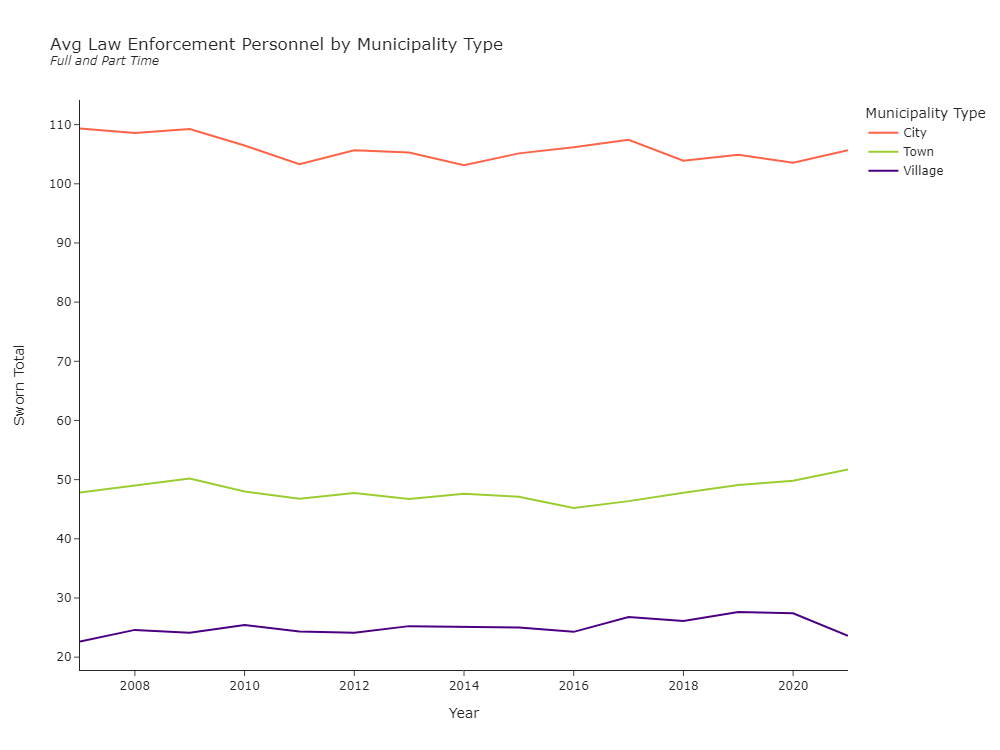

In [10]:
fig = px.line(merged.groupby(["Municipality Type","Year"]).mean().reset_index(),
                 x="Year",
                 y='Sworn Total',
                 color = "Municipality Type",
                 title="Avg Law Enforcement Personnel by Municipality Type<sup><br><i>Full and Part Time<i><sup>",
                 color_discrete_map={"City":"tomato","Town":"yellowgreen","Village":"indigo"},
                 template="simple_white").\
update_xaxes(matches=None, showticklabels=True, visible=True).\
update_yaxes(matches=None, showticklabels=True, visible=True)

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

Before we start building the model I will normalize the values that will inform the predictions. The dataset contains the property crimes and types, but it shows the full year reporting (or at least a fractional number of months that were reported). We cannot use these features as-is because we would not have access to the full year information if we wanted to make any predictions from current or real time data.

To adjust for this I will be creating two types of derived values that would allow for current data to be used. First, we will calculate individual crimes per month. At any point in time this value can be calculated and we would not need to wait for a full year worth of data. Second, I will calculate a very common metric which is crimes per 100,000. I will use the 2020 census numbers for each municipality.

In [11]:
#crimes per month
PropNorm = pd.concat([merged[['Year',"Economic Region","Municipality","Municipality Type",'2010 Census Population']],           
merged.iloc[:, 19:23].div(merged['Months Reported'].values,axis=0)],axis=1)

#crimes per 100k
PropPopNorm = (PropNorm.iloc[:, 5:9].div(PropNorm['2010 Census Population'].values,axis=0) *100000).add_suffix(' 100k')

PropNorm = pd.concat([PropNorm,PropPopNorm],axis=1).\
drop(PropNorm.filter(like=r"Total").columns.to_list()+['2010 Census Population'],axis=1)
PropNorm

,Year,Economic Region,Municipality,Municipality Type,Burglary,Larceny,Motor Vehicle Theft,Property Total 100k,Burglary 100k,Larceny 100k,Motor Vehicle Theft 100k
0,2007,Capital District,Albany,City,80.250000,249.750000,23.833333,361.585731,82.008257,255.221959,24.355516
1,2008,Capital District,Albany,City,86.166667,264.166667,18.750000,377.169855,88.054556,269.954491,19.160808
2,2009,Capital District,Albany,City,73.083333,261.666667,19.416667,361.926368,74.684571,267.399717,19.842081
3,2010,Capital District,Albany,City,76.916667,290.750000,18.833333,394.968116,78.601891,297.120258,19.245967
4,2011,Capital District,Albany,City,74.166667,295.583333,14.000000,392.157865,75.791639,302.059489,14.306736
...,...,...,...,...,...,...,...,...,...,...,...
2699,2013,Finger Lakes,Warsaw,Village,0.416667,6.083333,0.000000,187.158077,11.997313,175.160764,0.000000
2700,2015,Finger Lakes,Warsaw,Village,0.916667,5.583333,0.000000,187.158077,26.394088,160.763989,0.000000
2701,2018,Finger Lakes,Warsaw,Village,0.750000,4.083333,0.083333,141.568289,21.595163,117.573663,2.399463
2702,2020,Finger Lakes,Warsaw,Village,0.416667,2.083333,0.083333,74.383338,11.997313,59.986563,2.399463


I want to check the correlations between all the variables to determine which of them I can will choose to retain, preprocess ,or combine to avoid coliniarity.

C:\Users\arua\AppData\Local\Temp\ipykernel_16536\225802485.py:5: FutureWarning:

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.



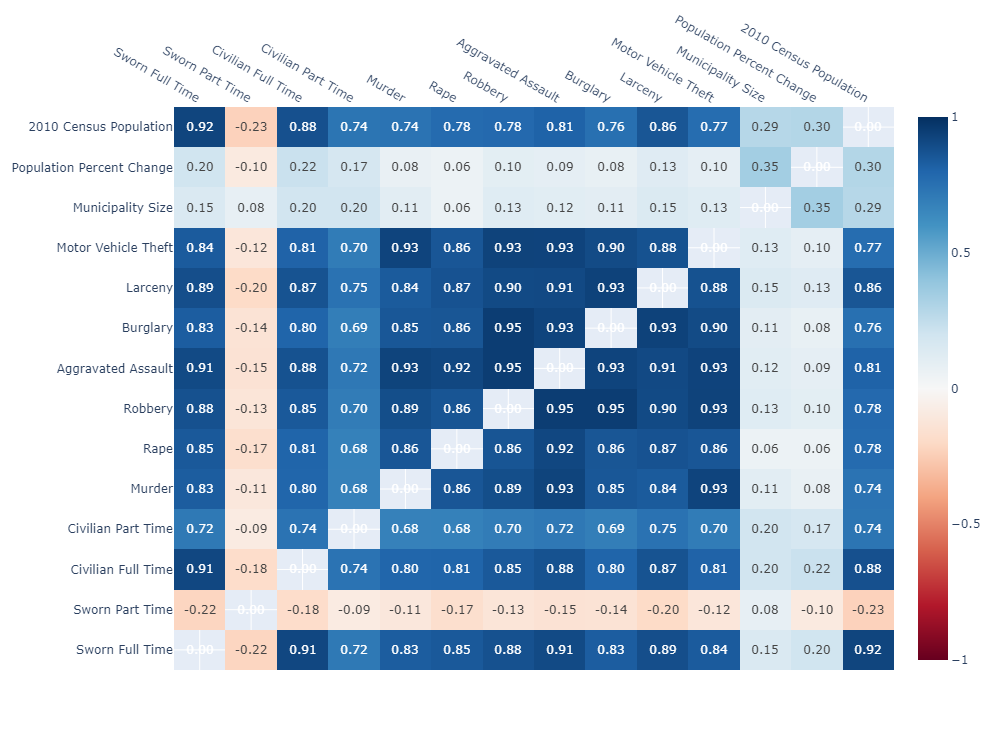

In [12]:
import plotly.express as px
import plotly.graph_objects as go
from IPython.display import Image

corrplt =  merged.drop(merged.filter(like=r"Total"),axis=1)\
.drop(['Months Reported','Year'],axis=1).corr()

fig = go.Figure(go.Heatmap(
        x = corrplt.columns,
        y = corrplt.index,
        z = np.array(corrplt.replace(1,np.nan)),
        text=corrplt.replace(1,np.nan).values,
        texttemplate='%{text:.2f}',
        colorscale = px.colors.diverging.RdBu,
         zmin=-1, zmax=1)).update_xaxes(side="top").\
         update_traces(hovertemplate='%{x} to %{y}<br> Correlation <b>%{z}')

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)

Here I import all the relevent libraries and create the `mergedModel` dataset to combine the `merged` dataframe with `PropNorm` dataset with all of the normalized crime data. I set the target field, the Violent Total to a variable named `target`. I drop the crime per 100k and retain the total per 100k to avoid coliniarity.

In [13]:
from scikeras.wrappers import KerasRegressor
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA,KernelPCA
from sklearn.model_selection import train_test_split,RandomizedSearchCV,StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler,FunctionTransformer,KBinsDiscretizer,StandardScaler,OneHotEncoder,OrdinalEncoder,PowerTransformer,MinMaxScaler
from sklearn.metrics import *
import scipy.stats as stats
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Dropout,Input
from tensorflow.keras.callbacks import EarlyStopping

mergedModel = merged[['Year',"Municipality","Municipality Type",
'Sworn Full Time','Sworn Part Time','Violent Total',
'Municipality Size',"Economic Region"]].merge(PropNorm,how='left').\
drop(['Burglary 100k','Larceny 100k','Motor Vehicle Theft 100k'],axis=1).\
drop_duplicates(subset=['Year',"Municipality","Municipality Type"]).\
dropna()

target = 'Violent Total'

Next, I build a Keras model and wrap it in `KerasRegressor` to use in a sk-learn pipeline. I've added 3 hidden layers with a few hundred neutrons and placed to dropout layers between then. I'm using the `Adam` optimizer and setting the batch size to 50 and running for 120 epochs.

In [129]:
def build_model(meta):
    reg = tf.keras.Sequential()
    reg.add(Input(shape=(meta["n_features_in_"])))
    reg.add(Dense(100, activation='relu',kernel_initializer=tf.keras.initializers.Orthogonal()))
    reg.add(Dense(150, activation='relu'))
    reg.add(Dense(75, activation='relu'))
    reg.add(Dense(1,activation = 'linear'))
    reg.compile(optimizer=keras.optimizers.Adam(learning_rate = 0.005,use_ema=True),
                loss = 'mean_absolute_percentage_error')
    return reg
modelCrime = KerasRegressor(build_model,
epochs=120,
validation_split = 0.05,
batch_size = 50,
verbose=0,
optimizer=keras.optimizers.Adam(learning_rate = 0.005,use_ema=True)
)

After building the model I'll incorporate it into a pipeline to preprocess. Since all of our property crimes are highly correlated, I decompose it into 2 principal components with `PCA`. I also chose to discretize the property crime rate into 5 bins with equal data points to stratify the lowest to highest crime rate areas.

Finally, I split the data into training and test.

In [141]:
pipe = make_pipeline(ColumnTransformer(
transformers = [
('OHE',OneHotEncoder(),['Economic Region','Municipality Type']),
("PCA",PCA(n_components = 2),['Burglary','Larceny','Motor Vehicle Theft']),
("scale",MinMaxScaler(),['Sworn Full Time','Sworn Part Time']),
("KB",KBinsDiscretizer(strategy='quantile',encode='ordinal',n_bins=5),['Property Total 100k']),

  ],
remainder = 'passthrough'),
modelCrime)

train,test = train_test_split(mergedModel,train_size = .80)

X = train.drop([target,'Municipality',"Year"],axis = 1)
Y = train[[target]].values

Take a glimpse at the the final dataset and fit the model.

In [142]:
mergedModel.sample(10)

,Year,Municipality,Municipality Type,Sworn Full Time,Sworn Part Time,Violent Total,Municipality Size,Economic Region,Burglary,Larceny,Motor Vehicle Theft,Property Total 100k
508,2020,Buffalo,City,752,0,2706.0,5.0,Western New York,130.666667,462.583333,112.000000,269.890169
648,2018,Evans,Town,22,3,22.0,5.0,Western New York,2.583333,11.583333,0.666667,90.690470
2636,2008,Pelham,Village,28,0,8.0,5.0,Downstate,1.833333,9.666667,0.166667,168.837434
1086,2021,Greece,Town,94,0,132.0,5.0,Western New York,16.000000,122.500000,13.000000,157.656486
1669,2017,Blooming Grove,Town,10,2,11.0,5.0,Downstate,1.583333,3.250000,0.333333,28.659123
1312,2013,Niagara,Town,5,19,13.0,4.0,Western New York,4.000000,36.000000,1.166667,491.366277
603,2019,Amherst,Town,152,0,141.0,5.0,Western New York,13.083333,136.666667,3.583333,125.307139
2052,2012,Glenville,Town,22,0,17.0,5.0,Capital District,3.833333,29.916667,0.333333,115.615106
1779,2014,Phoenix,Village,0,15,6.0,3.0,Central New York,0.916667,1.583333,0.000000,104.953820
1412,2007,Manlius,Town,38,0,18.0,5.0,Central New York,4.666667,31.000000,1.000000,113.273607


In [143]:
pipe.fit(X, Y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('OHE', OneHotEncoder(),
                                                  ['Economic Region',
                                                   'Municipality Type']),
                                                 ('PCA', PCA(n_components=2),
                                                  ['Burglary', 'Larceny',
                                                   'Motor Vehicle Theft']),
                                                 ('scale', MinMaxScaler(),
                                                  ['Sworn Full Time',
                                                   'Sworn Part Time']),
                                                 ('KB',
                                                  KBinsDiscretizer(encode='ordinal'),
                                                  ['Property Total 100k'])])),
                ('kerasregressor',
                 KerasRegressor(batch_size=50, epochs=120, model=<function build_model at 0x0000024C71059160>, optimizer=<keras.optimizers.optimizer_experimental.adam.Adam object at 0x0000024C7220F160>, validation_split=0.05, verbose=0))])

I add the predictions and percent difference to columns in the `test` dataframe 

In [144]:
test[target+'_prediction'] = pipe.predict(test.drop([target,'Municipality',"Year"],axis = 1)).round()
test[target+'_prediction_diff'] = round((test[target+'_prediction'] - test[target])/test[target],5)

Finally, I check the R-Squared to determine if the model is reliable. A score of ~.98 implies the model is reliably predicting on the test data. The scatter plot displays the dispersion between the actual vs predicted and shows the residuals.

In [148]:
r2_score(test[target],test[target+'_prediction']).round(2)

0.98

In [146]:
mean_absolute_percentage_error(test[target],test[target+'_prediction'])

0.2813196447428633

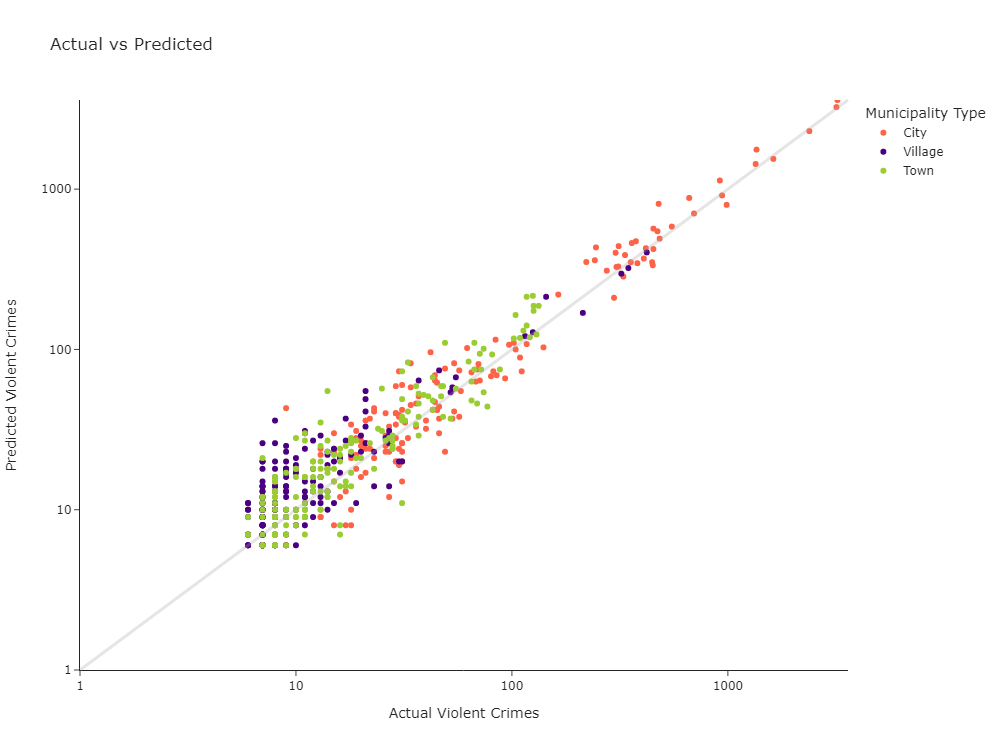

In [147]:
axisMax = np.log10(test[target].max())

fig = px.scatter(test,y=target,x=target+'_prediction',
           title="Actual vs Predicted",
           color="Municipality Type",
           template="simple_white",
           log_x = True,
           log_y = True,
           color_discrete_map={"City":"tomato","Town":"yellowgreen","Village":"indigo"},
           custom_data=['Municipality']).\
update_layout(yaxis_range=[0,axisMax],xaxis_range=[0,axisMax]).\
update_yaxes(title="Predicted Violent Crimes",dtick=1).\
update_xaxes(title="Actual Violent Crimes",dtick=1).\
add_shape(type="line",
    xref="paper", yref="paper",
    x0=0, y0=0, x1=1,
    y1=1,
    line=dict(
        color="darkgrey",
        width=3,
    ))

fig = fig.to_image(engine="orca",width=1000, height=750)
Image(fig)